# Text mining project

The goal of this project is to analyze the subreddit WritingPrompts, this subreddit posts are topics for stories, then those topics have comments with stories. Each topic and storie has upvotes which is what we will use for classify if a storie/topic is good or bad. The goal is to detect which are the important characteristics of the stories/posts with high upvotes.  
  
With that in mind we will use 2 different types of algorithms, first we will use algorithms depending on a bag of words, and then an LSTM which also takes into consideration the order of words etc. 
  
First we import all the libraries needed. 

In [1]:
import praw
from datetime import datetime
import urllib
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,GRU, SpatialDropout1D
from keras.optimizers import RMSprop, Adadelta,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import LinearSVC
import gensim
%matplotlib inline

C:\Users\jandr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\jandr\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Extract the data

In order to extract data from reddit we had to create a developer account and an application for reddit. After that we can use it to extract the data from reddit using API such as PRAW and pushshift.io

In [5]:
reddit = praw.Reddit(user_agent='WritinPromptsAnalisis',
                     client_id='69trSZ8K-_rtuw', client_secret="e807hpHIQ-BcPf0-iAjVD6KD6JM")

subreddit = reddit.subreddit('WritingPrompts')

We test the pushshift.io retrieval for reddit, it works better because we can use a time parameter to extract the information, we save the data into a json because pushshift returns a json simil.  
  
When extracted the data for the first time it was extracted sorted by new posts. The data is distributed exponentially with the score, there are lots of post with 0 upvotes and deleted when sorted that way, therefore there was a lot of noise in the data.  
  
To eliminate that noise, the data is extracted sorted in a descending order of the upvotes, that way the posts obtained are the ones with more than 10 upvotes and being relevant.  
  
As the maximum amount of submissions is 1000 we loop 20 times after the latest submission to get aorund 20000 submissions id.

In [ ]:
url = "https://api.pushshift.io/reddit/submission/search/?after=100d&before=90d&sort_type=score&sort=desc&subreddit=writingprompts&fields=id,created_utc,num_comments,score,title&size=1000"
data = json.load(urllib.request.urlopen(url))

for i in range(0,20):
    url = "https://api.pushshift.io/reddit/submission/search/?after="+str(100+(i*10))+"d&before="+str(90+(i*10))+"d&sort_type=score&sort=desc&subreddit=writingprompts&fields=id,created_utc,num_comments,score,title&size=1000"    
    for item in json.load(urllib.request.urlopen(url))["data"]:
        data["data"].append(item)
    print("\rProcessed {}".format(i),end="",flush="True")
    
jsonfile = json.dumps(data)
file = open("data.json", "w+")
file.write(jsonfile)
file.close()

To get better data we use the praw library to get the stories, the score of the stories and a more reliable score of the title and then we save the data

In [6]:
i=0
for stre in data["data"]:
    submission = reddit.submission(id=stre["id"])
    if(len(submission.comments)>1):
        stre["score"] = submission.score
        stre["num_comments"] = submission.num_comments
        stre["stories"] = [comments.body for comments in submission.comments[0:16]]
        stre["stories_score"] = [comments.score for comments in submission.comments[0:16]]    
    print("\rProcessed {}".format(i),end="",flush="True")
    i = i+1

jsonfile = json.dumps(data)
file = open("data2.json", "w+")
file.write(jsonfile)
file.close()


Processed 20999

Now the data must be filtered ---Still need to get the stories---

In [2]:
data = json.load(open("data.json", "r"))

df = pd.DataFrame(data=data["data"])
df = df.dropna()

#stories = [stori for stories in df.stories for stori in stories[1:]]
#score = [stori for stories in df.stories_score for stori in stories[1:]]
#len_stories = [len(nltk.word_tokenize(x)) for x in stories]

df["logscore"] = np.log(df.score)
mean = np.mean(df.logscore)

df["score_bin"] = df.logscore.apply(lambda x: 1 if x > mean else 0)
df = df.sample(frac=1)

df["len"] = [len(nltk.word_tokenize(x)) for x in df.title]
df = df.drop_duplicates()
train_set, test_set = df[int(len(df)*0.2):], df[:int(len(df)*0.2)]

xtrain = train_set.title
ytrain = train_set.score_bin
xtest = test_set.title


The distribution of the data is the one shown below, and exponential, for that reason to delete outliers and scale the data a bit better we will use the log of the score.

Text(0.5,1,'Histogram of score')

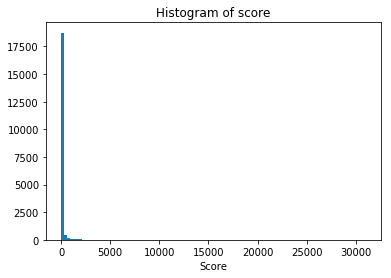

In [13]:
plt.hist(df.score, 100)
plt.xlabel('Score')
plt.title('Histogram of score')

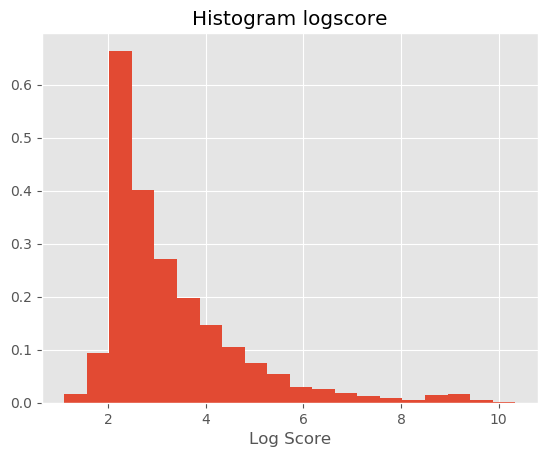

In [116]:
plt.style.use("ggplot")
plt.hist(df.logscore, 20, density=True)
plt.xlabel('Log Score')
plt.title('Histogram logscore')
plt.savefig("histlogscore.png")

When getting the highest 1000 posts from the last 10 days we get the distributions above, were there are barely any posts which are below 8, but this way there's not so much noise.


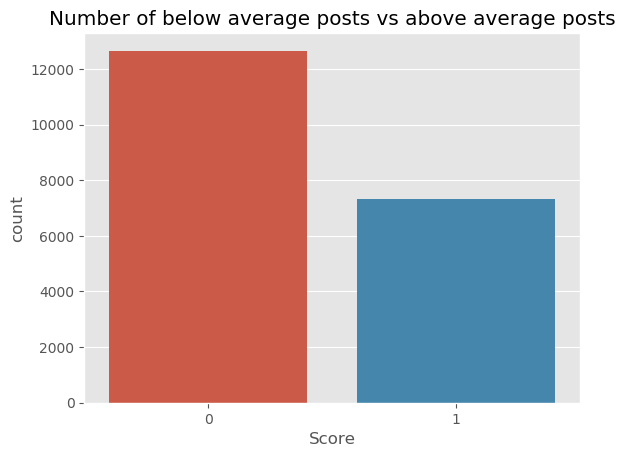

In [119]:
sns.countplot(df.score_bin)
plt.xlabel('Score')
plt.title('Number of below average posts vs above average posts')
plt.savefig("classes.png")

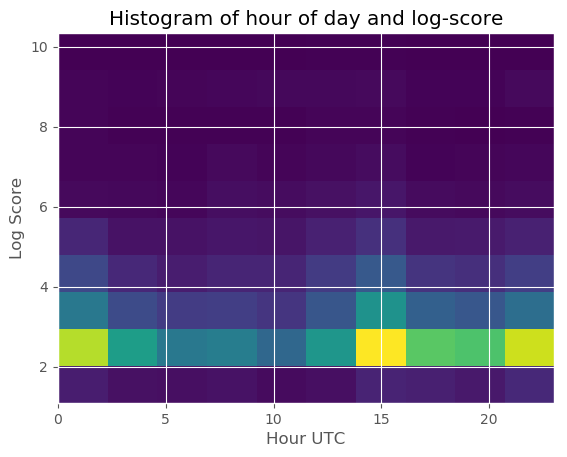

In [122]:
dd = df
x = dd.logscore
y = [datetime.utcfromtimestamp(x).hour for x in dd.created_utc]
plt.hist2d(y,x)
plt.title("Histogram of hour of day and log-score")
plt.ylabel("Log Score")
plt.xlabel("Hour UTC")
plt.savefig("utc.png")

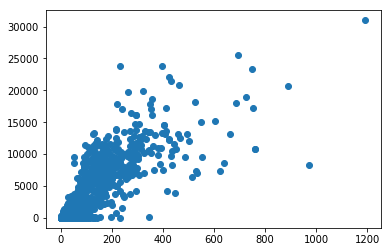

In [12]:
x = df.score
y = df.num_comments
plt.scatter(y, x)
plt.show()

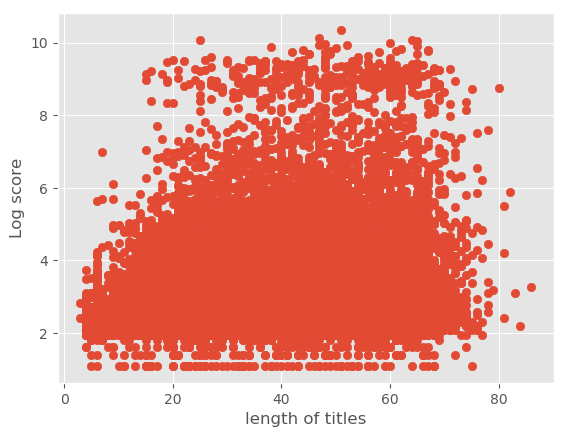

In [123]:
x = df.logscore
y = df.len
plt.scatter(y, x)
plt.xlabel("length of titles")
plt.ylabel("Log score")
plt.savefig("len.png")

# Classification

Once the data is clean, the next step is to build the algorithms to test the classifiers.

First preprocessing the data to fit in the classification algorithm.

    - Delete stopwords
    - Delete non english words
    - Stemming the words

Naive Bayes Classifier.

In [79]:

stemmer = SnowballStemmer("english", ignore_stopwords=True)
#stop_words= set(stopwords.words('english'))
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words=None)
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('mnb', MultinomialNB(fit_prior=False)),])
text_mnb_stemmed = text_mnb_stemmed.fit(xtrain, ytrain)
predicted_mnb_stemmed = text_mnb_stemmed.predict(xtest)
print(np.mean(predicted_mnb_stemmed == test_set.score_bin))
print(confusion_matrix(predicted_mnb_stemmed, test_set.score_bin))
np.mean(cross_val_score(text_mnb_stemmed, xtrain, ytrain, cv=5, scoring="accuracy"))

0.611
[[2166 1157]
 [ 399  278]]


array([0.60324898, 0.605625  , 0.6096875 , 0.5975    , 0.60143795])

Random Forest Classifier

In [82]:
text_rf_stemmed = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('mnb', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)),])
text_rf_stemmed = text_rf_stemmed.fit(xtrain,ytrain)
predicted_rf_stemmed = text_rf_stemmed.predict(xtest)
print(np.mean(predicted_rf_stemmed == test_set.score_bin))
print(confusion_matrix(predicted_rf_stemmed, test_set.score_bin))
np.mean(cross_val_score(text_rf_stemmed, xtrain, ytrain, cv=5, scoring="accuracy"))

0.64125
[[2565 1435]
 [   0    0]]


0.6308750051086431

Linear Super Vector Machine

In [81]:
text_rf_stemmed = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('mnb', LinearSVC()),])
text_rf_stemmed = text_rf_stemmed.fit(xtrain,ytrain)
predicted_rf_stemmed = text_rf_stemmed.predict(xtest)
print(np.mean(predicted_rf_stemmed == test_set.score_bin))
print(confusion_matrix(predicted_rf_stemmed, test_set.score_bin))
np.mean(cross_val_score(text_rf_stemmed, xtrain, ytrain, cv=5, scoring="accuracy"))

0.58925
[[1877  955]
 [ 688  480]]


0.5908750621826233

Logistic Regression

In [80]:
text_rf_stemmed = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('mnb', LogisticRegression(random_state=0)),])
text_rf_stemmed = text_rf_stemmed.fit(xtrain,ytrain)
predicted_rf_stemmed = text_rf_stemmed.predict(xtest)
print(np.mean(predicted_rf_stemmed == test_set.score_bin))
print(confusion_matrix(predicted_rf_stemmed, test_set.score_bin))
np.mean(cross_val_score(text_rf_stemmed, xtrain, ytrain, cv=5, scoring="accuracy"))

0.62625
[[2259 1189]
 [ 306  246]]


0.6177502391418691

SGDClassifier

In [84]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='log', penalty='l2',
                                            alpha=3e-5, n_iter=200, random_state=0)),])
_ = text_clf_svm.fit(xtrain,ytrain)
predicted_svm = text_clf_svm.predict(xtest)
print(np.mean(predicted_svm == test_set.score_bin))
print(confusion_matrix(predicted_svm, test_set.score_bin))
np.mean(cross_val_score(text_clf_svm, xtrain, ytrain, cv=5, scoring="accuracy"))

C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.6215
[[2131 1080]
 [ 434  355]]


C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\jandr\Anaconda3\lib\site-packages\sklearn\linear_model\stochast

0.6081250629150452

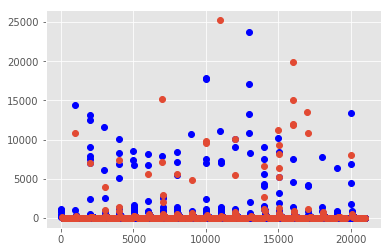

In [8]:

final = pd.DataFrame(data=[df.loc[x] for x in test_set.index])
final["score_pred"] = predicted_rf_stemmed
plt.style.use('ggplot')
plt.plot(final[final.score_pred==0].score, "bo")
plt.plot(final[final.score_pred==1].score,"o")
plt.show()


## LSTM

In this step the classification of the posts will be done by an LSTM, this way the information given to the algorithm will also be how the text flows, which may change the classification of it.

In [85]:
X = df.title
Y = df.score_bin
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
max_words = 12000
max_len = 86
tok = Tokenizer(num_words=max_words, lower=True)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [66]:
np.mean(df.len)

39.64165

Define the RNN

In [86]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,8,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [87]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 86)                0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 86, 8)             96000     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               70144     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [88]:
pred = model.predict(test_sequences_matrix)
Y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred))
matrix = confusion_matrix(Y_test, Y_pred)
print(matrix)
acc=(matrix[0,0]+matrix[1,1])/sum(sum(matrix))
print(acc)

[[2249  303]
 [1162  286]]
0.63375


# Topic modeling with LDA

Now in order to check if there's any topic that has a significant difference of upvotes regarding others, which would mean that there's a group of words that have more weight to get upvotes, LDA will be executed.

In [3]:
stop_words= set(stopwords.words('english'))
from nltk.stem import PorterStemmer
words = set(nltk.corpus.words.words())
stemer = PorterStemmer()
token = RegexpTokenizer(r'\w+')

def preprocess(ret):
    word_tokens = token.tokenize(ret)[1:]
    lower_words = [w.lower() for w in word_tokens]
    filtered_word = [w for w in lower_words if not w in stop_words] 
    english_words = [w for w in filtered_word if w in words] 
    stemed_words = [w for w in english_words if w not in "one"]
    stemed_words = [stemer.stem(w) for w in stemed_words]
    return(stemed_words)

In [102]:
processed_docs = df.title.map(preprocess)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(xtrain)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [103]:
for i in range(10, 11):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=i, id2word=dictionary, passes=2, workers=2)
    print("Number of topics {}".format(i))
    print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

Number of topics 10

Perplexity:  -7.303992451283309

Coherence Score:  0.2784642562779956


In [97]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"human" + 0.015*"alien" + 0.014*"earth" + 0.011*"find" + 0.008*"door" + 0.008*"come" + 0.007*"first" + 0.007*"day" + 0.007*"race" + 0.007*"war"
Topic: 1 
Words: 0.022*"find" + 0.018*"know" + 0.010*"get" + 0.009*"day" + 0.008*"never" + 0.007*"hous" + 0.007*"way" + 0.007*"littl" + 0.007*"come" + 0.007*"world"
Topic: 2 
Words: 0.016*"peopl" + 0.013*"world" + 0.012*"live" + 0.011*"see" + 0.010*"everyon" + 0.010*"day" + 0.010*"earth" + 0.009*"life" + 0.008*"back" + 0.008*"end"
Topic: 3 
Words: 0.039*"time" + 0.015*"travel" + 0.013*"die" + 0.012*"life" + 0.012*"day" + 0.010*"back" + 0.010*"peopl" + 0.009*"last" + 0.009*"death" + 0.009*"like"
Topic: 4 
Words: 0.017*"peopl" + 0.012*"human" + 0.011*"world" + 0.010*"wish" + 0.010*"good" + 0.010*"day" + 0.010*"turn" + 0.009*"technolog" + 0.008*"everi" + 0.008*"go"
Topic: 5 
Words: 0.030*"world" + 0.019*"magic" + 0.015*"power" + 0.013*"day" + 0.008*"super" + 0.008*"get" + 0.007*"old" + 0.007*"tri" + 0.007*"becom" + 0.006*"us

In [81]:
df["topic"] = [sorted(lda_model[dictionary.doc2bow(preprocess(title))], key=lambda tup: -1*tup[1])[0][0] for title in df.title]


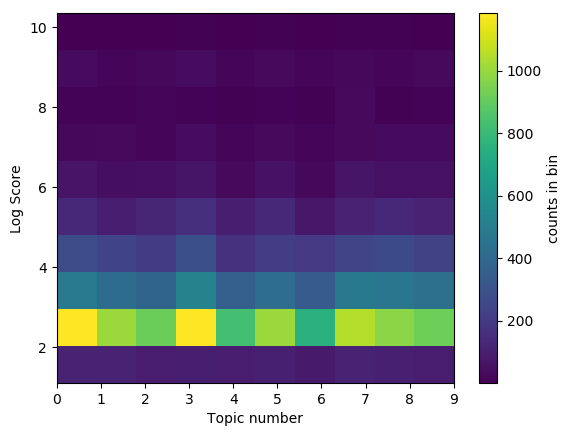

In [113]:
plt.style.use("default")
y = df.logscore
x = df.topic
plt.hist2d(x,y)
cb = plt.colorbar()
cb.set_label('counts in bin')
plt.ylabel("Log Score")
plt.xlabel("Topic number")
#plt.show()
plt.savefig("Topics.png")

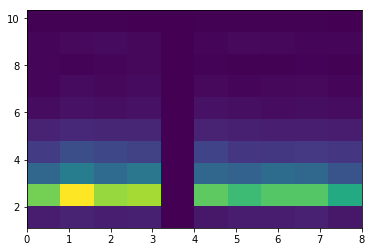

In [20]:
y = df.logscore
x = df.topic
plt.hist2d(x,y)
plt.show()

In [11]:

print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.212998767274685

Coherence Score:  0.21658918775674058


In [108]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.092917 -0.111506       1        1  12.140925
9      0.048126 -0.001137       2        1  11.821028
8      0.077838 -0.008370       3        1  11.094934
7     -0.002134 -0.057502       4        1  10.363816
6      0.048621 -0.034850       5        1   9.785065
2     -0.016296  0.015980       6        1   9.476512
4      0.084295  0.038230       7        1   9.334441
3     -0.024942  0.003978       8        1   9.211034
5     -0.029320  0.055165       9        1   8.869469
1     -0.093272  0.100013      10        1   7.902782, topic_info=         Term         Freq        Total Category  logprob  loglift
term                                                              
477     human  1690.000000  1690.000000  Default  30.0000  30.0000
20      earth  1386.000000  1386.000000  Default  29.0000  29.0000
239      time  2519.000000  2519.000000  Default  28.0000  28.0000
25     planet   518.000000   518.000000  Default  27.0000  27.0000
143       see  1206.000000  1206.000000  Default  26.0000  26.0000
1194    alien   540.000000   540.000000  Default  25.0000  25.0000
462     magic   609.000000   609.000000  Default  24.0000  24.0000
264     speci   343.000000   343.000000  Default  23.0000  23.0000
104      good   514.000000   514.000000  Default  22.0000  22.0000
306      wish   297.000000   297.000000  Default  21.0000  21.0000
281     space   396.000000   396.000000  Default  20.0000  20.0000
360     demon   356.000000   356.000000  Default  19.0000  19.0000
49      stori   663.000000   663.000000  Default  18.0000  18.0000
116       get  1390.000000  1390.000000  Default  17.0000  17.0000
259       dog   293.000000   293.000000  Default  16.0000  16.0000
37    everyon  1060.000000  1060.000000  Default  15.0000  15.0000
91       hell   455.000000   455.000000  Default  14.0000  14.0000
121     death   736.000000   736.000000  Default  13.0000  13.0000
4         day  2558.000000  2558.000000  Default  12.0000  12.0000
218      find  1648.000000  1648.000000  Default  11.0000  11.0000
245    travel   482.000000   482.000000  Default  10.0000  10.0000
393       use   658.000000   658.000000  Default   9.0000   9.0000
119     becom   849.000000   849.000000  Default   8.0000   8.0000
257      wake   747.000000   747.000000  Default   7.0000   7.0000
333       man   781.000000   781.000000  Default   6.0000   6.0000
290     write   567.000000   567.000000  Default   5.0000   5.0000
351      save   369.000000   369.000000  Default   4.0000   4.0000
370      geni   170.000000   170.000000  Default   3.0000   3.0000
713      race   261.000000   261.000000  Default   2.0000   2.0000
809     night   566.000000   566.000000  Default   1.0000   1.0000
...       ...          ...          ...      ...      ...      ...
316    killer    62.029961   177.732910  Topic10  -5.6464   1.4853
76       dark    89.626045   339.254486  Topic10  -5.2784   1.2069
606    crimin    34.861523    73.470490  Topic10  -6.2226   1.7925
360     demon    84.660126   356.610199  Topic10  -5.3354   1.1000
31      world   246.993912  2416.923828  Topic10  -4.2646   0.2571
175      want    88.493652   392.480316  Topic10  -5.2911   1.0484
290     write   105.807961   567.728088  Topic10  -5.1124   0.8579
1141    crime    55.446255   171.614410  Topic10  -5.7586   1.4081
164      love    87.526634   404.832886  Topic10  -5.3021   1.0064
634      high    60.630455   204.951447  Topic10  -5.6692   1.3200
230      best    88.133224   424.031982  Topic10  -5.2952   0.9670
695     super    76.188942   326.549652  Topic10  -5.4408   1.0826
244      make   121.615868   888.684509  Topic10  -4.9731   0.5491
34      peopl   160.746017  1627.650024  Topic10  -4.6942   0.2229
79       turn   119.551384   940.884583  Topic10  -4.9903   0.4749
167      need    76.598351   355.354340  Topic10  -5.4354   1.0034
477     human   147.538986